In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Base SIM_DOFET

In [4]:
df_sim = pd.read_csv('./base_limpa/base_sim_dofet_limpa_remocao.csv')

In [5]:
df_sim_agreg_regiao = pd.DataFrame(
    df_sim.groupby(['cat_periodo_nasc', 'cat_peso_calc', 'ocor_REGIAO']).agg(Tamanho=('data_obito', 'size'))
).reset_index()

In [6]:
# Removendo covid e zika
df_sim_agreg_regiao_covid_zika = pd.DataFrame(
    df_sim[~df_sim['ano_obito'].isin([2015, 2017, 2020, 2021, 2022])].groupby(['cat_periodo_nasc', 'cat_peso_calc', 'ocor_REGIAO']).agg(Tamanho=('data_obito', 'size'))
).reset_index()

In [7]:
df_sim_agreg_brasil = pd.DataFrame(
    df_sim.groupby(['cat_periodo_nasc', 'cat_peso_calc']).agg(Tamanho=('data_obito', 'size'))
).reset_index()

In [8]:
# Removendo covid e zika
df_sim_agreg_brasil_covid_zika = pd.DataFrame(
    df_sim[~df_sim['ano_obito'].isin([2015, 2017, 2020, 2021, 2022])].groupby(['cat_periodo_nasc', 'cat_peso_calc']).agg(Tamanho=('data_obito', 'size'))
).reset_index()

In [9]:
del df_sim

# Base SINASC

In [11]:
df_sinasc = pd.read_csv('./base_limpa/base_sinasc_limpa_remocao.csv')

In [13]:
df_sinasc_agreg_regiao = pd.DataFrame(
    df_sinasc.groupby(['cat_periodo_nasc', 'cat_peso_calc', 'nasc_REGIAO']).agg(Tamanho=('data_nasc', 'size'))
).reset_index()

In [14]:
# Removendo covid e zika
df_sinasc_agreg_regiao_covid_zika = pd.DataFrame(
    df_sinasc[~df_sinasc['ano_nasc'].isin([2015, 2017, 2020, 2021, 2022])].groupby(['cat_periodo_nasc', 'cat_peso_calc', 'nasc_REGIAO']).agg(Tamanho=('data_nasc', 'size'))
).reset_index()

In [15]:
df_sinasc_agreg_brasil = pd.DataFrame(
    df_sinasc.groupby(['cat_periodo_nasc', 'cat_peso_calc']).agg(Tamanho=('data_nasc', 'size'))
).reset_index()

In [16]:
# Removendo covid e zika
df_sinasc_agreg_brasil_covid_zika = pd.DataFrame(
    df_sinasc[~df_sinasc['ano_nasc'].isin([2015, 2017, 2020, 2021, 2022])].groupby(['cat_periodo_nasc', 'cat_peso_calc']).agg(Tamanho=('data_nasc', 'size'))
).reset_index()

In [23]:
del df_sinasc

# Cálculos todos os anos 

In [25]:
def calculate_rr(df_obito, df_nasc, region=None):
    if region:
        df_obito = df_obito[df_obito['ocor_REGIAO'] == region].reset_index(drop=True)
        df_nasc = df_nasc[df_nasc['nasc_REGIAO'] == region].reset_index(drop=True)
    
    df_obito['group'] = 'Termo_AIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'termo') & (df_obito['cat_peso_calc'] == 'PIG'), 'group'] = 'Termo_PIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'pre_termo') & (df_obito['cat_peso_calc'] == 'AIG'), 'group'] = 'Pre_Termo_AIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'pre_termo') & (df_obito['cat_peso_calc'] == 'PIG'), 'group'] = 'Pre_Termo_PIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'termo') & (df_obito['cat_peso_calc'] == 'GIG'), 'group'] = 'Termo_GIG'
    df_obito.loc[(df_obito['cat_periodo_nasc'] == 'pre_termo') & (df_obito['cat_peso_calc'] == 'GIG'), 'group'] = 'Pre_Termo_GIG'
    
    df_nasc['group'] = 'Termo_AIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'termo') & (df_nasc['cat_peso_calc'] == 'PIG'), 'group'] = 'Termo_PIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'pre_termo') & (df_nasc['cat_peso_calc'] == 'AIG'), 'group'] = 'Pre_Termo_AIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'pre_termo') & (df_nasc['cat_peso_calc'] == 'PIG'), 'group'] = 'Pre_Termo_PIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'termo') & (df_nasc['cat_peso_calc'] == 'GIG'), 'group'] = 'Termo_GIG'
    df_nasc.loc[(df_nasc['cat_periodo_nasc'] == 'pre_termo') & (df_nasc['cat_peso_calc'] == 'GIG'), 'group'] = 'Pre_Termo_GIG'
    
    deaths = df_obito.groupby('group')['Tamanho'].sum()
    births = df_nasc.groupby('group')['Tamanho'].sum()
    
    rr_results = []
    comparisons = [
        ('Termo_AIG', 'Termo_PIG'),
        ('Termo_AIG', 'Pre_Termo_AIG'),
        ('Termo_AIG', 'Pre_Termo_PIG'),
        ('Termo_AIG', 'Termo_GIG'),
        ('Termo_AIG', 'Pre_Termo_GIG')
    ]
    
    for ref, exp in comparisons:
        if ref in deaths and exp in deaths and ref in births and exp in births:
            rate_exp = deaths[exp] / births[exp]
            rate_ref = deaths[ref] / births[ref]
            rr = rate_exp / rate_ref
            
            ci_lower = rr * np.exp(-1.96 * np.sqrt((1/deaths[exp]) + (1/deaths[ref])))
            ci_upper = rr * np.exp(1.96 * np.sqrt((1/deaths[exp]) + (1/deaths[ref])))
            
            rr_results.append({
                'Region': region if region else 'Brasil',
                'Comparison': f'{exp} vs {ref}',
                'RR': round(rr, 2),
                'CI Lower': round(ci_lower, 2),
                'CI Upper': round(ci_upper, 2)
            })
    
    return pd.DataFrame(rr_results)


In [26]:
df_brasil_geral = calculate_rr(df_obito=df_sim_agreg_brasil, df_nasc=df_sinasc_agreg_brasil)
# Exibindo os resultados
display(df_brasil_geral)

,Region,Comparison,RR,CI Lower,CI Upper
0,Brasil,Termo_PIG vs Termo_AIG,3.74,3.67,3.81
1,Brasil,Pre_Termo_AIG vs Termo_AIG,24.90,24.53,25.28
2,Brasil,Pre_Termo_PIG vs Termo_AIG,77.36,76.24,78.49
3,Brasil,Termo_GIG vs Termo_AIG,2.21,2.15,2.27
4,Brasil,Pre_Termo_GIG vs Termo_AIG,19.60,19.26,19.94


In [27]:
df_regioes_geral = pd.concat([calculate_rr(df_obito=df_sim_agreg_regiao, df_nasc=df_sinasc_agreg_regiao, region=region) for region in df_sim_agreg_regiao['ocor_REGIAO'].unique()])
display(df_regioes_geral)

,Region,Comparison,RR,CI Lower,CI Upper
0,Centro-Oeste,Termo_PIG vs Termo_AIG,3.82,3.58,4.08
1,Centro-Oeste,Pre_Termo_AIG vs Termo_AIG,27.56,26.13,29.07
2,Centro-Oeste,Pre_Termo_PIG vs Termo_AIG,89.36,84.86,94.10
3,Centro-Oeste,Termo_GIG vs Termo_AIG,2.37,2.16,2.61
4,Centro-Oeste,Pre_Termo_GIG vs Termo_AIG,22.61,21.28,24.03
0,Nordeste,Termo_PIG vs Termo_AIG,3.70,3.59,3.81
1,Nordeste,Pre_Termo_AIG vs Termo_AIG,21.83,21.28,22.40
2,Nordeste,Pre_Termo_PIG vs Termo_AIG,69.21,67.53,70.93
3,Nordeste,Termo_GIG vs Termo_AIG,2.20,2.11,2.30
4,Nordeste,Pre_Termo_GIG vs Termo_AIG,13.32,12.93,13.71


In [28]:
df_brasil_geral.to_csv('resultado/rr_obitos_c_nasc_brasil.csv', index=False)
df_regioes_geral.to_csv('resultado/rr_obitos_c_nasc_regiao.csv', index=False)

In [29]:
def graf_box_plot(df, nome_graf):
    # Configurações do gráfico
    fig, ax = plt.subplots(figsize=(10, 6))  # Tamanho do gráfico
    
    # Definindo as posições no eixo x
    x = np.arange(len(df['Comparison']))  # Posições para cada comparação
    width = 0.4  # Largura das barras
    
    # Definindo as cores das barras e barras de erro
    cores_barras = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Cores das barras
    cor_erro = 'black'  # Cor das barras de erro
    
    # Plotando as barras para o RR
    bars = ax.bar(x, df['RR'], width, label='RR', color=cores_barras, alpha=0.7)
    
    # Adicionando as barras de erro para os intervalos de confiança
    ax.errorbar(x, df['RR'], yerr=[df['RR'] - df['CI Lower'], df['CI Upper'] - df['RR']], 
                fmt='o', color=cor_erro, label='95% CI', capsize=5)
    
    # Adicionando os valores de RR ao lado direito de cada barra
    for i, rr in enumerate(df['RR']):
        ax.text(x[i] + width/2 + 0.05, rr, f'RR: {rr:.2f}', ha='left', va='center', fontsize=10, color='black')
    
    # Adicionando texto e labels
    ax.set_xlabel("Newborn types", fontsize=12)
    ax.set_ylabel("Stillbirth Relative Risk (RR)", fontsize=12)
    ax.set_title("Relative Risk Stillbirth and Confidence Intervals by Newborn type", fontsize=14)
    
    # Definindo os rótulos do eixo x
    ax.set_xticks(x)
    ax.set_xticklabels(df['Comparison'], rotation=45, ha="right", fontsize=10)
    
    # Adicionando uma linha de referência em RR = 1 (nenhum efeito)
    ax.axhline(y=1, color='gray', linestyle='--', linewidth=1, label='No Effect (RR = 1)')
    
    # Adicionando legenda
    ax.legend(fontsize=10)
    
    # Ajustando layout para não cortar labels
    fig.tight_layout()
    
    # Salvando a figura
    plt.savefig(nome_graf, dpi=300, bbox_inches='tight')
    
    # Mostrando o gráfico
    plt.show()

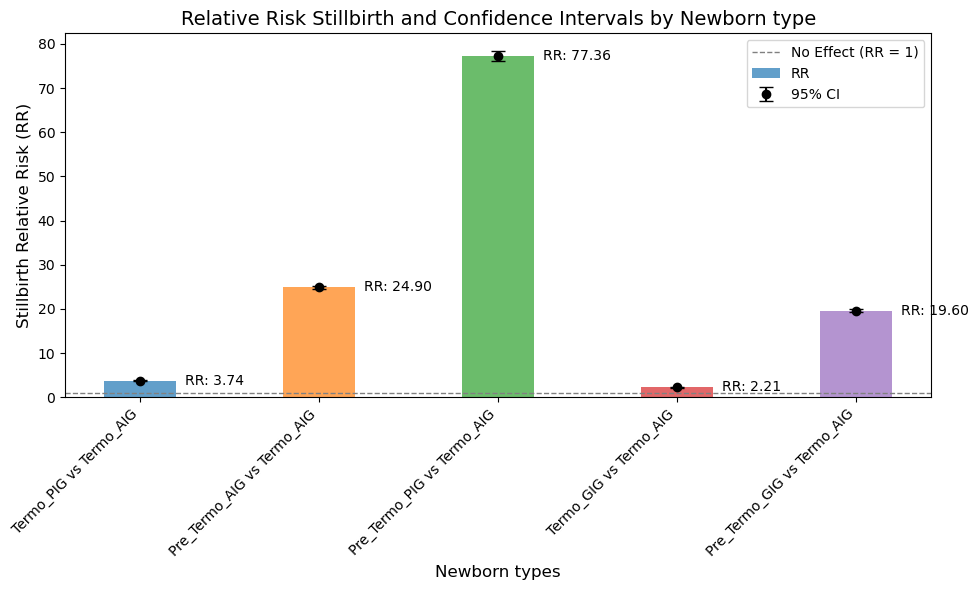

In [41]:
graf_box_plot(df=df_brasil_geral, nome_graf='./graficos/box_plot_brasil_todos_os_anos_RR_com_nasc.png')

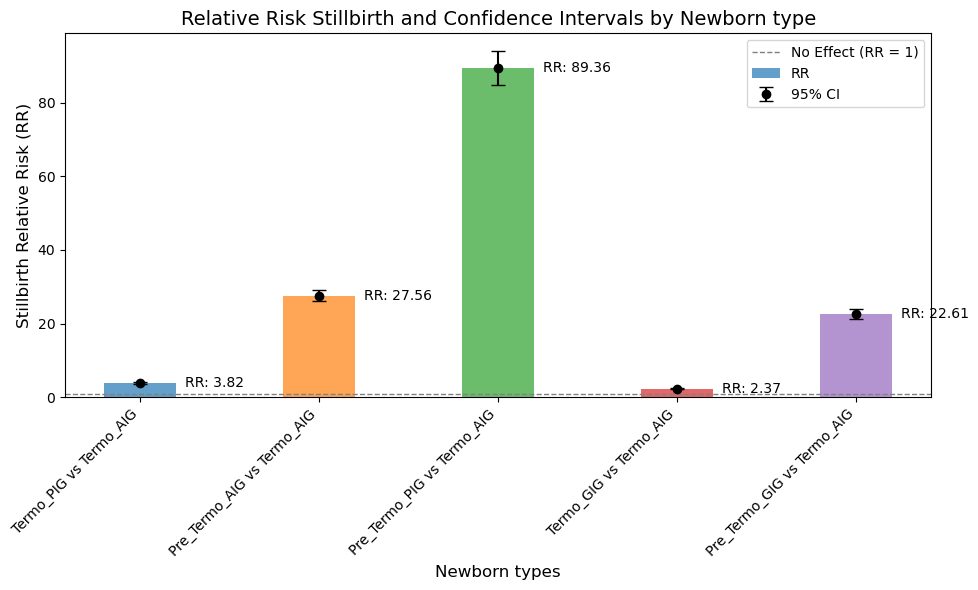

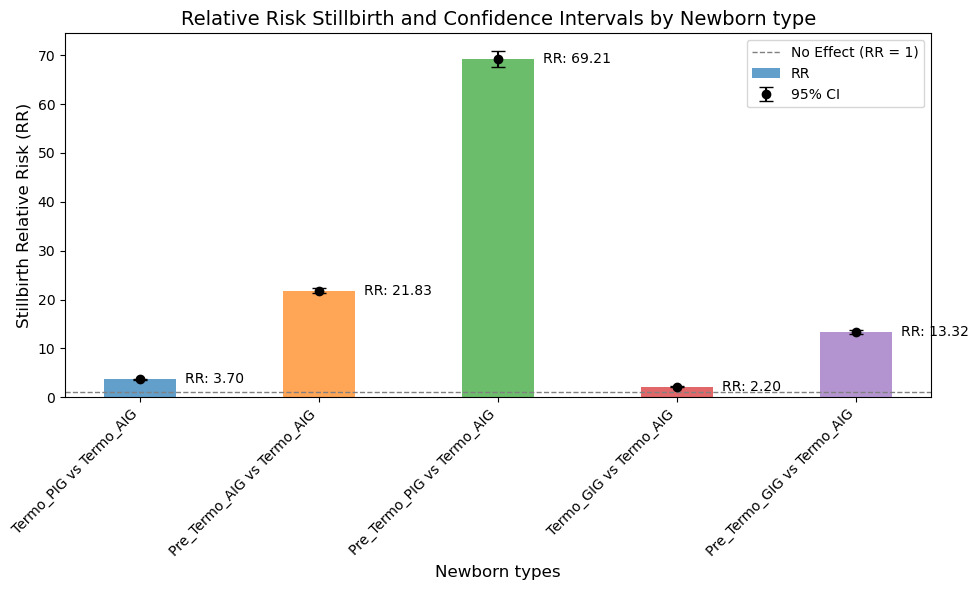

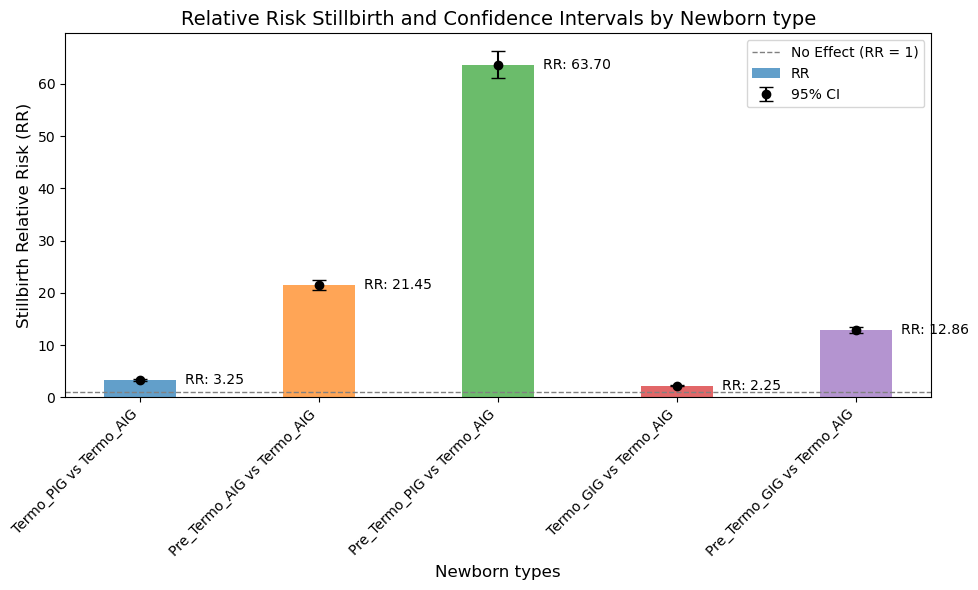

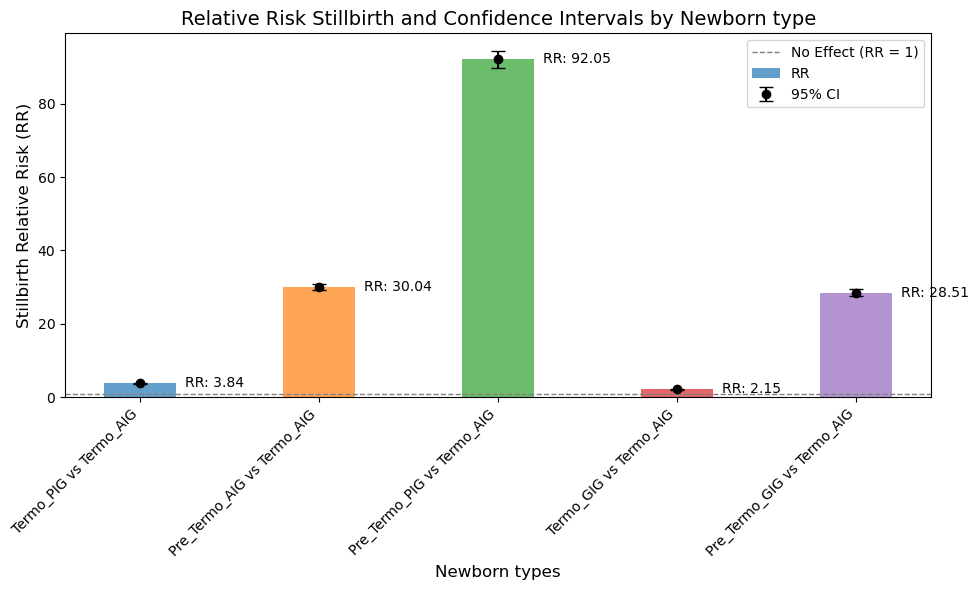

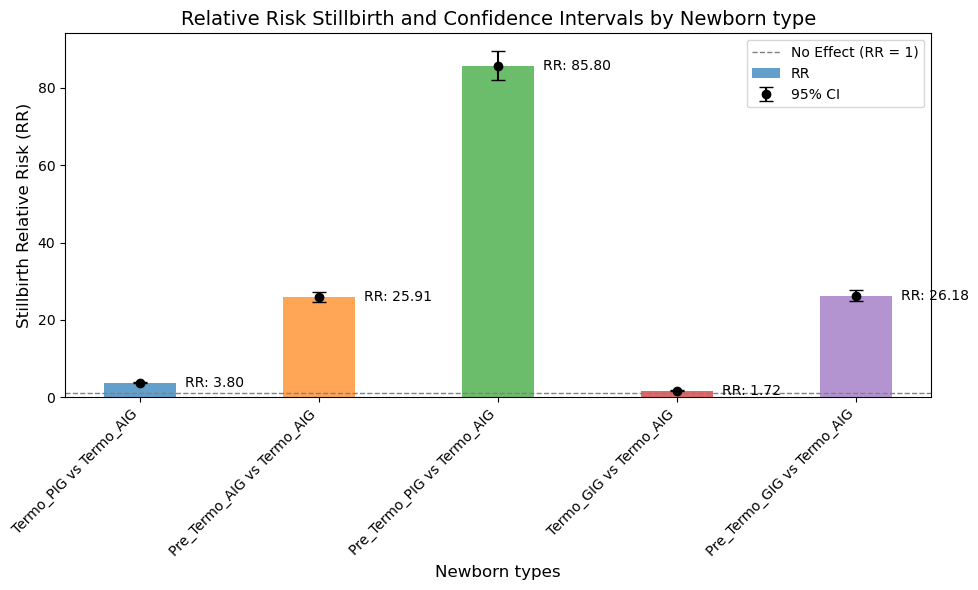

In [47]:
vet_reg = pd.unique(df_regioes_geral['Region'])
for reg in vet_reg:
    df_graf_reg = df_regioes_geral[df_regioes_geral['Region']==reg].reset_index(drop=True)
    path = f'./graficos/box_plot_{reg}_todos_os_anos_RR_com_nasc.png'
    graf_box_plot(df=df_graf_reg, nome_graf=path)

C:\Users\gabri\AppData\Local\Temp\ipykernel_3784\67614609.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x="Comparison", y="RR_100", data=df_graf_geral, palette=["#D8A4C8", "#F4D03F", "#6C3483", "#1F618D"])
C:\Users\gabri\AppData\Local\Temp\ipykernel_3784\67614609.py:6: UserWarning: 
The palette list has fewer values (4) than needed (5) and will cycle, which may produce an uninterpretable plot.
  ax = sns.boxplot(x="Comparison", y="RR_100", data=df_graf_geral, palette=["#D8A4C8", "#F4D03F", "#6C3483", "#1F618D"])


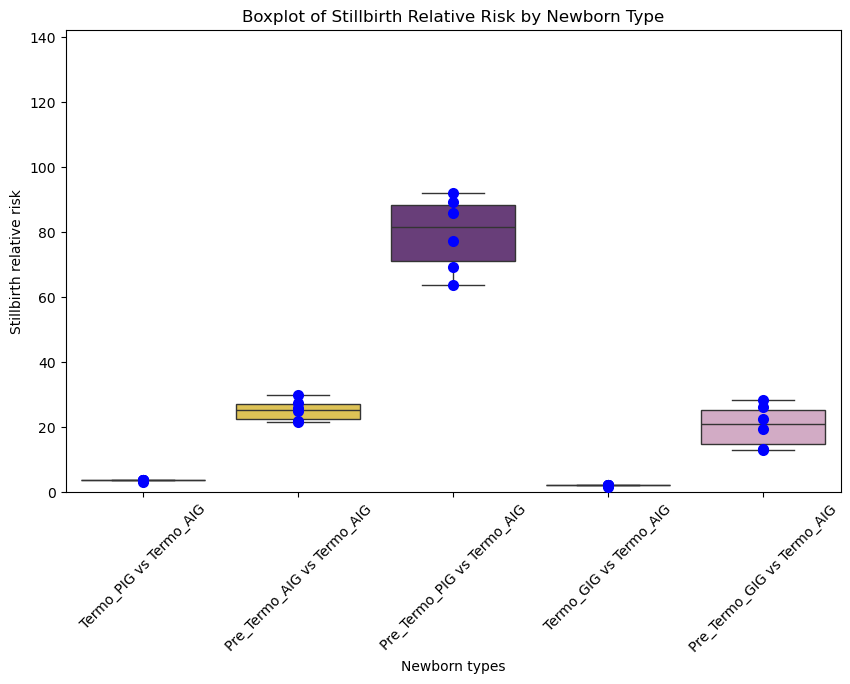

In [17]:
#df_graf_geral = pd.concat([df_regioes_geral, df_brasil_geral])
#df_graf_geral['RR_100'] = df_graf_geral['RR']
#
## Criar o boxplot
#plt.figure(figsize=(10, 6))  # Aumentar tamanho do gráfico
#ax = sns.boxplot(x="Comparison", y="RR_100", data=df_graf_geral, palette=["#D8A4C8", "#F4D03F", "#6C3483", "#1F618D"])
#
## Adicionar pontos médios
#sns.stripplot(x="Comparison", y="RR_100", data=df_graf_geral, color="blue", size=8, jitter=False)
#
## Adicionar rótulos dos valores
## for i, value in enumerate(df_graf["RR_100"]):
##     plt.text(i, value + 5, f"{value:.1f}", ha='center', fontsize=10, fontweight='bold')
#
## Configurações do gráfico
#plt.ylabel("Stillbirth relative risk")
#plt.xlabel("Newborn types")
#plt.ylim(0, max(df_graf_geral["RR_100"]) + 50)  # Ajustar limite superior
#plt.xticks(rotation=45)
#plt.title("Boxplot of Stillbirth Relative Risk by Newborn Type")
#
## Mostrar o gráfico
#plt.show()

# Cálculo ZIKA e COVID

In [49]:
df_brasil_covid_zika = calculate_rr(df_obito=df_sim_agreg_brasil_covid_zika, df_nasc=df_sinasc_agreg_brasil_covid_zika)
# Exibindo os resultados
display(df_brasil_covid_zika)

,Region,Comparison,RR,CI Lower,CI Upper
0,Brasil,Termo_PIG vs Termo_AIG,3.72,3.63,3.82
1,Brasil,Pre_Termo_AIG vs Termo_AIG,24.43,23.91,24.95
2,Brasil,Pre_Termo_PIG vs Termo_AIG,75.68,74.15,77.25
3,Brasil,Termo_GIG vs Termo_AIG,2.25,2.17,2.33
4,Brasil,Pre_Termo_GIG vs Termo_AIG,19.01,18.55,19.47


In [51]:
df_regioes_covid_zika = pd.concat([calculate_rr(df_obito=df_sim_agreg_regiao_covid_zika, df_nasc=df_sinasc_agreg_regiao_covid_zika, region=region) for region in df_sim_agreg_regiao['ocor_REGIAO'].unique()])
display(df_regioes_covid_zika)

,Region,Comparison,RR,CI Lower,CI Upper
0,Centro-Oeste,Termo_PIG vs Termo_AIG,3.87,3.53,4.25
1,Centro-Oeste,Pre_Termo_AIG vs Termo_AIG,27.49,25.49,29.65
2,Centro-Oeste,Pre_Termo_PIG vs Termo_AIG,86.47,80.33,93.07
3,Centro-Oeste,Termo_GIG vs Termo_AIG,2.42,2.12,2.77
4,Centro-Oeste,Pre_Termo_GIG vs Termo_AIG,21.56,19.79,23.49
0,Nordeste,Termo_PIG vs Termo_AIG,3.68,3.53,3.83
1,Nordeste,Pre_Termo_AIG vs Termo_AIG,21.63,20.86,22.42
2,Nordeste,Pre_Termo_PIG vs Termo_AIG,67.82,65.51,70.21
3,Nordeste,Termo_GIG vs Termo_AIG,2.19,2.07,2.33
4,Nordeste,Pre_Termo_GIG vs Termo_AIG,13.11,12.58,13.65


In [53]:
df_brasil_covid_zika.to_csv('resultado/rr_obitos_c_nasc_brasil_covid_zika.csv', index=False)
df_regioes_covid_zika.to_csv('resultado/rr_obitos_c_nasc_regiao_covid_zika.csv', index=False)

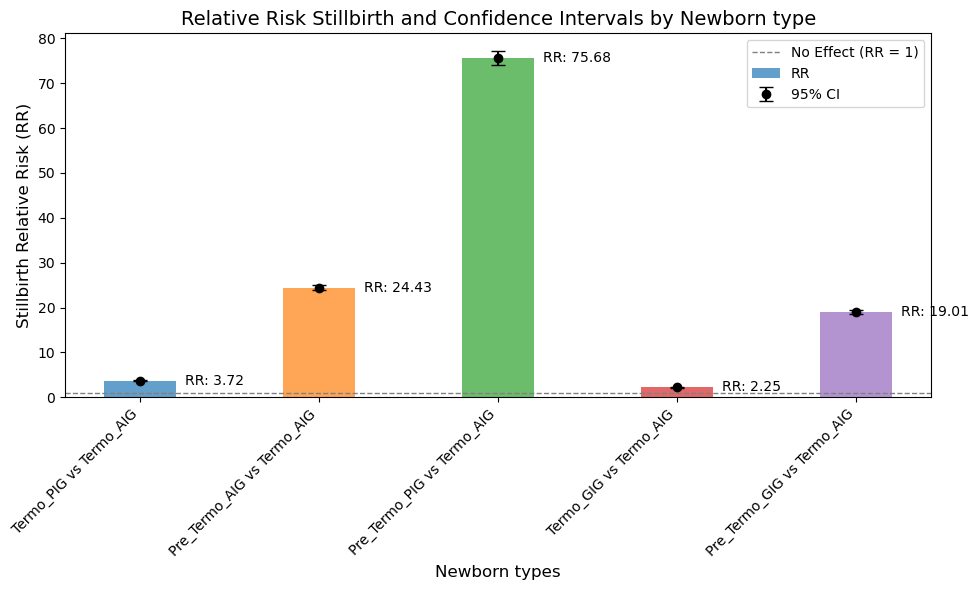

In [55]:
graf_box_plot(df_brasil_covid_zika, nome_graf='./graficos/box_plot_brasil_sem_zika_covid_os_anos_RR_com_nasc.png')

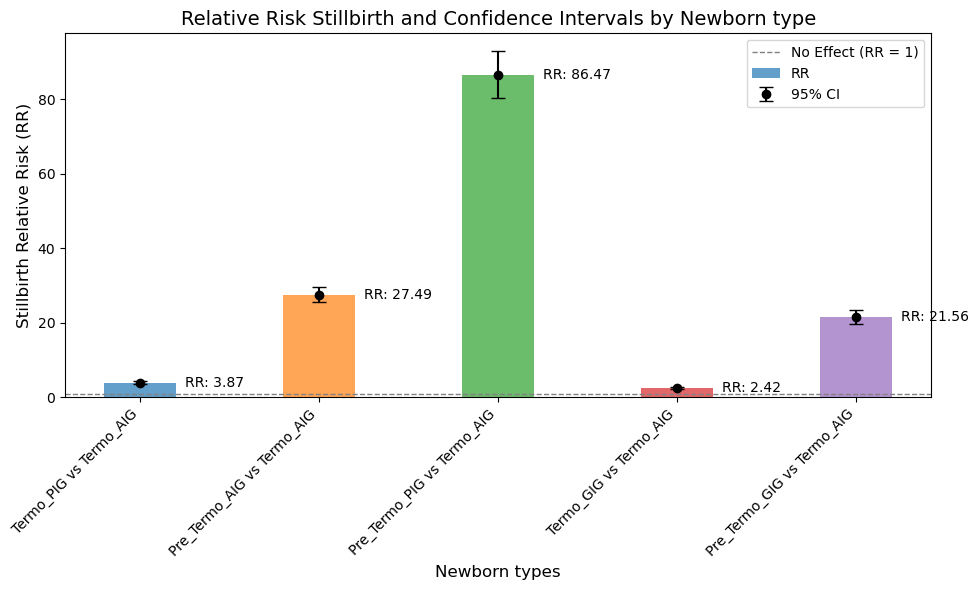

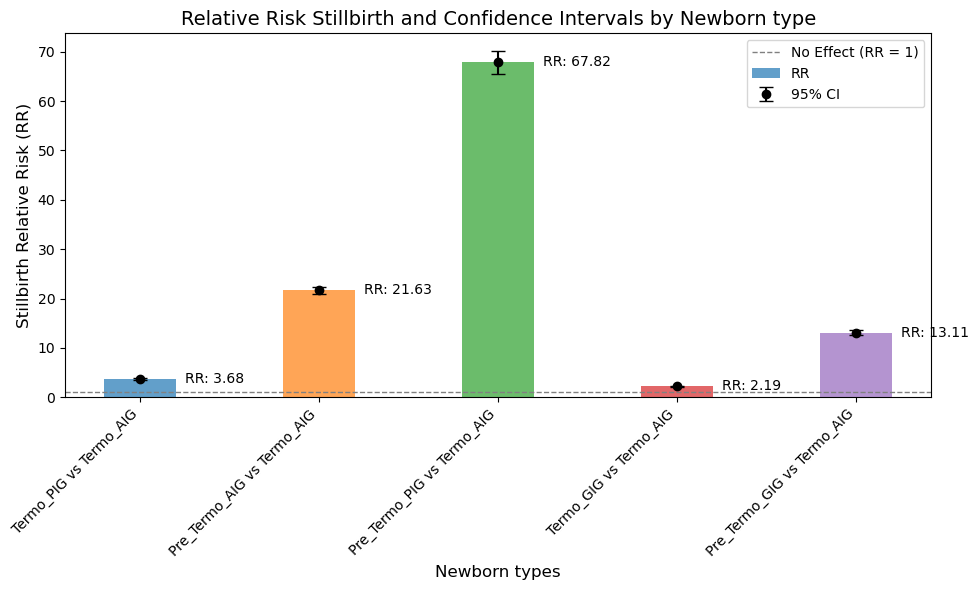

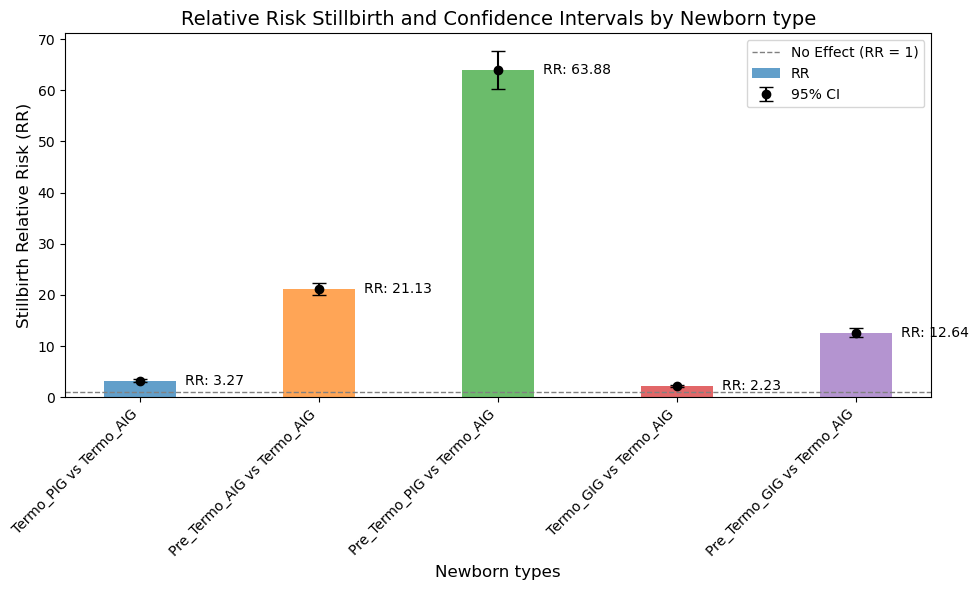

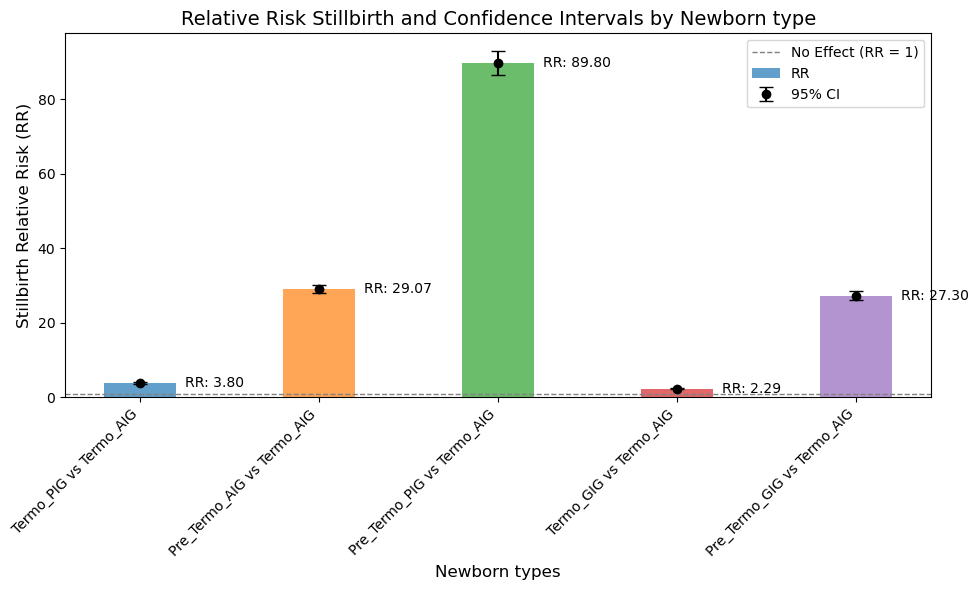

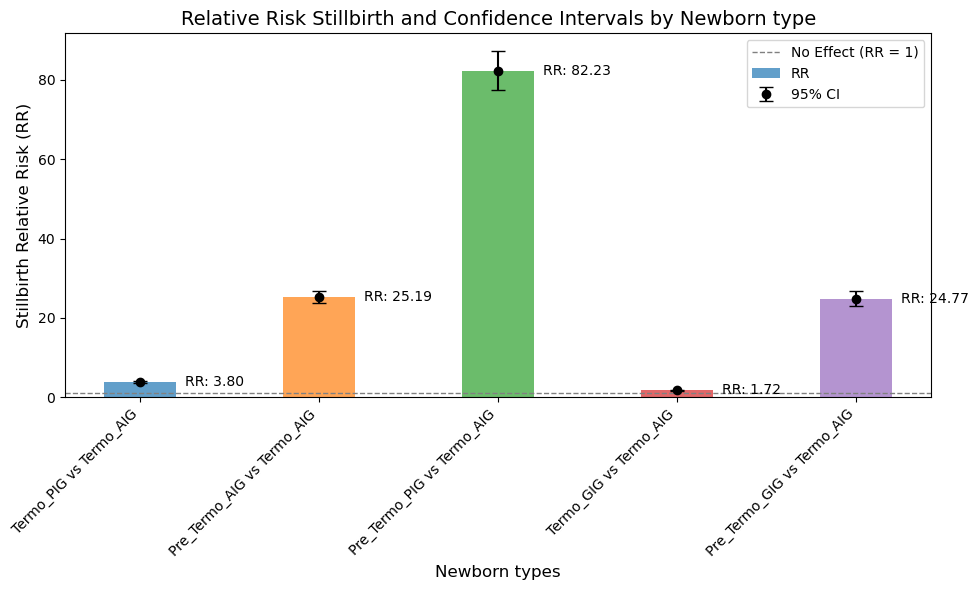

In [57]:
vet_reg = pd.unique(df_regioes_covid_zika['Region'])
for reg in vet_reg:
    df_graf_reg = df_regioes_covid_zika[df_regioes_covid_zika['Region']==reg].reset_index(drop=True)
    path = f'./graficos/box_plot_{reg}_sem_zika_covid_RR_com_nasc.png'
    graf_box_plot(df=df_graf_reg, nome_graf=path)

In [ ]:
#df_graf_covid_zika = pd.concat([df_regioes_covid_zika, df_brasil_covid_zika])
#df_graf_covid_zika['RR_100'] = df_graf_covid_zika['RR']*100
#
## Criar o boxplot
#plt.figure(figsize=(10, 6))  # Aumentar tamanho do gráfico
#ax = sns.boxplot(x="Comparison", y="RR_100", data=df_graf_covid_zika, palette=["#D8A4C8", "#F4D03F", "#6C3483", "#1F618D"])
#
## Adicionar pontos médios
#sns.stripplot(x="Comparison", y="RR_100", data=df_graf_covid_zika, color="blue", size=8, jitter=False)
#
## Adicionar rótulos dos valores
## for i, value in enumerate(df_graf["RR_100"]):
##     plt.text(i, value + 5, f"{value:.1f}", ha='center', fontsize=10, fontweight='bold')
#
## Configurações do gráfico
#plt.ylabel("Stillbirth relative risk")
#plt.xlabel("Newborn types")
#plt.ylim(0, max(df_graf_covid_zika["RR_100"]) + 50)  # Ajustar limite superior
#plt.xticks(rotation=45)
#plt.title("Boxplot of Stillbirth Relative Risk by Newborn Type")
#
## Mostrar o gráfico
#plt.show()

# Análise geral

1. Brasil Geral

Os resultados indicam que a prematuridade é o principal fator de risco para óbito fetal.

O grupo Pre_Termo_PIG vs Termo_AIG apresenta o maior risco relativo (RR = 77.36), mostrando que bebês prematuros pequenos para idade gestacional têm uma vulnerabilidade extrema.

O grupo Pre_Termo_AIG vs Termo_AIG também exibe um risco elevado (RR = 24.90), reforçando que a prematuridade sozinha já é um fator de risco importante.

Bebês Termo_PIG vs Termo_AIG apresentam um risco 3.74 vezes maior de óbito, sugerindo que restrição de crescimento intrauterino também impacta negativamente a sobrevida.

O grupo Termo_GIG vs Termo_AIG (RR = 2.21) e Pre_Termo_GIG vs Termo_AIG (RR = 19.60) mostram que bebês grandes também enfrentam riscos elevados, principalmente quando são prematuros.

2. Região Geral

Há variações significativas entre as regiões:

Centro-Oeste tem os maiores riscos para Pre_Termo_PIG vs Termo_AIG (RR = 89.36) e Pre_Termo_AIG vs Termo_AIG (RR = 27.56), indicando que a prematuridade tem um impacto muito forte nessa região.

Nordeste apresenta riscos mais baixos para os grupos prematuros, com Pre_Termo_PIG vs Termo_AIG em 69.21 e Pre_Termo_AIG vs Termo_AIG em 21.83.

Norte é a região com menor impacto da prematuridade, com Pre_Termo_PIG vs Termo_AIG em 63.70 e Pre_Termo_AIG vs Termo_AIG em 21.45.

Sudeste tem os maiores valores de RR para Pre_Termo_PIG vs Termo_AIG (92.05) e Pre_Termo_AIG vs Termo_AIG (30.04), sugerindo que a prematuridade impacta mais essa região.

Sul apresenta um perfil semelhante ao Sudeste, com Pre_Termo_PIG vs Termo_AIG em 85.80 e Pre_Termo_AIG vs Termo_AIG em 25.91.

3. Brasil (Removendo Zika e COVID)

A remoção de eventos epidêmicos reduz levemente os riscos:

O Pre_Termo_PIG vs Termo_AIG cai de 77.36 para 75.68, e o Pre_Termo_AIG vs Termo_AIG diminui de 24.90 para 24.43.

Pequenas reduções também ocorrem para Pre_Termo_GIG vs Termo_AIG (de 19.60 para 19.01) e Termo_PIG vs Termo_AIG (de 3.74 para 3.72), sugerindo que Zika e COVID aumentavam levemente a mortalidade fetal.

4. Região (Removendo Zika e COVID)

Centro-Oeste continua tendo os maiores riscos, mas os valores diminuem levemente.

Nordeste e Norte mantêm a tendência de menor impacto da prematuridade.

Sudeste e Sul ainda apresentam os maiores riscos para Pre_Termo_PIG vs Termo_AIG e Pre_Termo_AIG vs Termo_AIG, mas com redução leve.

Comparativo Geral

O impacto da prematuridade é o maior fator de risco

O grupo Pre_Termo_PIG vs Termo_AIG apresenta os maiores RRs em todas as análises.

A remoção de Zika e COVID reduz os valores, mas o padrão permanece.

Diferenças regionais no impacto da prematuridade

O Sudeste tem os maiores riscos associados à prematuridade.

O Norte e Nordeste apresentam riscos menores para os prematuros.

Restrição de crescimento intrauterino agrava a prematuridade

Os riscos mais altos são para bebês Pre_Termo_PIG, independentemente da região.

Bebês Termo_PIG têm um risco elevado, mas menor comparado aos prematuros.

Bebês GIG têm um padrão misto

Termo_GIG vs Termo_AIG apresenta risco aumentado, mas não tanto quanto os prematuros.

Pre_Termo_GIG vs Termo_AIG tem menor impacto comparado a outros grupos prematuros.

Conclusão
A prematuridade combinada com restrição de crescimento é o maior fator de risco para óbito fetal, especialmente no Sudeste. A remoção de Zika e COVID reduz os riscos, mas não altera significativamente o padrão geral. Regiões como Norte e Nordeste apresentam menor impacto da prematuridade extrema, enquanto o Sudeste e Sul têm os maiores RRs para bebês prematuros.